# 1. Preprocess Data and Create Labels and Features

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import pandas as pd

from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Define Path to training data of numpy arrays
#DATA_PATH = os.path.join('MP_Data_bp_hp')
#DATA_PATH = os.path.join('MP_Data-6classes') # including facemesh

DATA_PATH = os.path.join('MP_Data') # including facemesh

# Define Model Run
run = 'run'

#Define directory to save training graphs and confusion matrices
img_dir = f'Logs/{run}/images'

# create directory if image directory does not exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)    

# Define actions that we try to detect
actions = np.array(['no', 'please', 'thanks', 'welcome', 'yes', 'noaction'])

# Sixty videos worth of data for each action
no_sequences = 60
# Videos are going to be 30 frames in length (30 frames of data for each action)
sequence_length = 30

#create label map dictionary
label_map = {label:num for num, label in enumerate(actions)} 
print(label_map)

#sequences represent x data, labels represent y data/the action classes.
sequences, labels = [], []
#Loop through the action classes you want to detect
for action in actions:
    #loop through each sequence
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# X = Training Data that contains spatial coordinates x,y,z of landmarks
X = np.array(sequences)

# y = categorical labels
y = to_categorical(labels).astype(int) #one-hot-encoding to catergorical variable

print('X Shape:',X.shape)
print('y Shape:',y.shape)

# train test split (80% train,20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

# split imbalanced dataset into train and test sets with stratification
test_count_label = tf.reduce_sum(y_test, axis=0)
train_count_label = tf.reduce_sum(y_train, axis=0)

{'no': 0, 'please': 1, 'thanks': 2, 'welcome': 3, 'yes': 4, 'noaction': 5}
X Shape: (360, 30, 258)
y Shape: (360, 6)
X_train Shape: (288, 30, 258)
y_train Shape: (288, 6)
X_test Shape: (72, 30, 258)
y_test Shape: (72, 6)


In [3]:
# Show categorical list
actions.tolist()

['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']

In [4]:
left = pd.DataFrame(train_count_label,columns=['train_count'])
right = pd.DataFrame(test_count_label,columns=['test_count'])
df = left.join(right)

actions_list = actions.tolist()

left = pd.DataFrame(actions_list,columns=['class_names'])
df = left.join(df)
df

,class_names,train_count,test_count
0,no,48,12
1,please,48,12
2,thanks,48,12
3,welcome,48,12
4,yes,48,12
5,noaction,48,12


In [5]:
left = pd.DataFrame(train_count_label,columns=['train_count'])
right = pd.DataFrame(test_count_label,columns=['test_count'])
df = left.join(right)

actions_list = actions.tolist()

left = pd.DataFrame(actions_list,columns=['class_names'])
df = left.join(df)
df

,class_names,train_count,test_count
0,no,48,12
1,please,48,12
2,thanks,48,12
3,welcome,48,12
4,yes,48,12
5,noaction,48,12


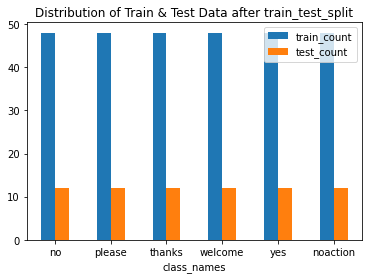

In [6]:
# Plot Distribution of Train & Test Data after train_test_split
ax = df.plot.bar(x='class_names',rot=0)
ax.set_title('Distribution of Train & Test Data after train_test_split')
ax.figure.savefig('Logs/run/images/train_test_distribution.jpg')

# 2. GRU Model

In [7]:
#Set up log directory to monitor training accuracy while training
log_dir = os.path.join('Logs/{}'.format(run))
tb_callback = TensorBoard(log_dir=log_dir)

model_dir = 'Logs/{}/model_GRU'.format(run)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [8]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam

# define the model
modelGRU = Sequential()
modelGRU.add(GRU(64, return_sequences=True, input_shape=(30, 258)))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(128, return_sequences=True))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(64, return_sequences=False))
modelGRU.add(Dense(64, activation='relu'))
#modelGRU.add(Dense(32, activation='relu'))
modelGRU.add(Dense(actions.shape[0], activation='softmax'))

In [9]:
modelGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            62208     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [10]:
#Compile defines the loss function, the optimizer and the metrics. 
modelGRU.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [11]:
epochs = 100
#checkpoint_dir = f"Logs/{run}/tmp/checkpoint"
model_filename = "Epoch-{epoch:02d}-Loss-{val_loss:.2f}.h5"
checkpoint_filepath = os.path.join('model_GRU/',model_filename)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'Logs/{run}/'+checkpoint_filepath,
    monitor='val_loss', #get the minimum validation loss
    mode='min',
    save_weights_only=True,
    save_best_only=True,
    verbose=2)

# Reference: https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
early_stopping =EarlyStopping(monitor='val_loss', patience=20,mode='auto',verbose=2)

In [12]:
#DO NOT RUN IF DONT WANT TO TRAIN
# Reference: https://www.tensorflow.org/guide/keras/train_and_evaluate
print(f"Fit model on training data for {epochs} epochs")
history_GRU = modelGRU.fit(
    X_train, y_train, 
    #batch_size=64,
    epochs=epochs,
    # We pass some validation data for monitoring validation loss and metrics at the end of each epoch
    validation_data=(X_test, y_test),
    verbose=2,
    batch_size=32,
    callbacks=[tb_callback, model_checkpoint_callback, early_stopping]
)

#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network


Fit model on training data for 100 epochs
Epoch 1/100

Epoch 1: val_loss improved from inf to 1.46823, saving model to Logs/run/model_GRU\Epoch-01-Loss-1.47.h5
9/9 - 7s - loss: 1.7061 - categorical_accuracy: 0.2986 - val_loss: 1.4682 - val_categorical_accuracy: 0.5139 - 7s/epoch - 754ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.46823 to 1.17522, saving model to Logs/run/model_GRU\Epoch-02-Loss-1.18.h5
9/9 - 0s - loss: 1.3802 - categorical_accuracy: 0.4410 - val_loss: 1.1752 - val_categorical_accuracy: 0.4306 - 325ms/epoch - 36ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.17522 to 0.96511, saving model to Logs/run/model_GRU\Epoch-03-Loss-0.97.h5
9/9 - 0s - loss: 1.1420 - categorical_accuracy: 0.5104 - val_loss: 0.9651 - val_categorical_accuracy: 0.5417 - 324ms/epoch - 36ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.96511 to 0.83761, saving model to Logs/run/model_GRU\Epoch-04-Loss-0.84.h5
9/9 - 0s - loss: 0.9662 - categorical_accuracy: 0.5660 - val_loss: 0.83

9/9 - 0s - loss: 0.0931 - categorical_accuracy: 0.9722 - val_loss: 0.1835 - val_categorical_accuracy: 0.9583 - 447ms/epoch - 50ms/step
Epoch 37/100

Epoch 37: val_loss did not improve from 0.13183
9/9 - 0s - loss: 0.0758 - categorical_accuracy: 0.9757 - val_loss: 0.1848 - val_categorical_accuracy: 0.9444 - 417ms/epoch - 46ms/step
Epoch 38/100

Epoch 38: val_loss did not improve from 0.13183
9/9 - 0s - loss: 0.0443 - categorical_accuracy: 0.9896 - val_loss: 0.1609 - val_categorical_accuracy: 0.9583 - 373ms/epoch - 41ms/step
Epoch 39/100

Epoch 39: val_loss did not improve from 0.13183
9/9 - 0s - loss: 0.0542 - categorical_accuracy: 0.9896 - val_loss: 0.1701 - val_categorical_accuracy: 0.9583 - 351ms/epoch - 39ms/step
Epoch 40/100

Epoch 40: val_loss did not improve from 0.13183
9/9 - 0s - loss: 0.0401 - categorical_accuracy: 0.9861 - val_loss: 0.1970 - val_categorical_accuracy: 0.9167 - 336ms/epoch - 37ms/step
Epoch 41/100

Epoch 41: val_loss improved from 0.13183 to 0.12161, saving mod

# 3. Plot Training Results

In [13]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_GRU.history) 

hist_df.to_csv(f'./Logs/{run}/history_GRU.csv',index = False)

df_hist = pd.read_csv(f'./Logs/{run}/history_GRU.csv')
hist_df

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.706073,0.298611,1.468225,0.513889
1,1.380199,0.440972,1.175222,0.430556
2,1.142000,0.510417,0.965114,0.541667
3,0.966224,0.565972,0.837614,0.666667
4,0.848684,0.628472,0.764740,0.736111
...,...,...,...,...
58,0.015894,0.993056,0.301346,0.930556
59,0.070905,0.972222,0.510622,0.861111
60,0.374757,0.909722,0.470187,0.902778
61,0.204636,0.930556,0.286475,0.916667


In [14]:
min_loss_epoch = hist_df[hist_df['loss']==min(hist_df['loss'])].index.values
min_loss = min(hist_df['loss'])
print('Index of Minimum Loss =',min_loss_epoch[0])
print('Minimum Loss =',round(min_loss,2))

Index of Minimum Loss = 56
Minimum Loss = 0.01


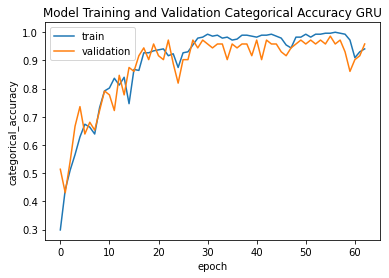

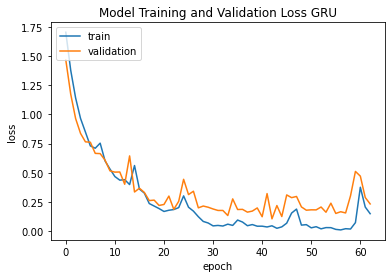

In [15]:
# summarize history for accuracy
plt.plot(history_GRU.history['categorical_accuracy'])
plt.plot(history_GRU.history['val_categorical_accuracy'])
plt.title('Model Training and Validation Categorical Accuracy GRU')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(f'{img_dir}/Model Training and Validation Categorical Accuracy GRU.jpg')
plt.show()

# summarize history for loss
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model Training and Validation Loss GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(f'{img_dir}/Model Training and Validation Loss GRU.jpg')
plt.show()

# 6. Load Best Model Weights/Checkpoint

In [17]:
#PATH: "C:\Users\yasmi\Desktop\data science\Logs\run_version2training\model\Epoch-72-Loss-0.15.h5"

modelGRU.load_weights("C:/Users/yasmi/Desktop/finalized ds project/Logs/run/model_GRU/Epoch-41-Loss-0.12.h5")

# 7. Make Predictions on X_test

In [18]:
res = modelGRU.predict(X_test)

# Get y_predict and apply softmax function
np.argmax(res[6])

3/3 [==============================] - 2s 13ms/step


3

In [19]:
# Predicted Action
actions[np.argmax(res[6])]

'welcome'

In [20]:
# Actual Action
actions[np.argmax(y_test[6])]

'welcome'

# 8. Model Evaluation (Categorical Accuracy and Confusion Matrix)
Running these cells converts the predicition from their one-hot encoded representation to a categorical label e.g. 0,1 or 2 as opposed to [1,0,0], [0,1,0] or [0,0,1].

In [21]:
X_test.shape

(72, 30, 258)

In [22]:
label_list = ['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']
label_list

['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']

In [23]:
label_list = list(label_map.keys())
label_list

['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']

In [24]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def generate_confusion_matrix_accuracy(X,y,types):
    predictions = modelGRU.predict(X)
    y_true = np.argmax(y, axis=1)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    print(f'{types} Overall Multiclassification Accuracy Score across all classes:',round(accuracy_score(y_true, y_pred),2))

    sns.heatmap(cm, xticklabels = label_list, yticklabels = label_list, annot = True, linewidths = 0.1, fmt='d',cmap='Blues') # cmap = 'YlGnBu')
    plt.title(f"{types} Confusion matrix", fontsize = 15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

9/9 [==============================] - 0s 16ms/step
Train Overall Multiclassification Accuracy Score across all classes: 1.0


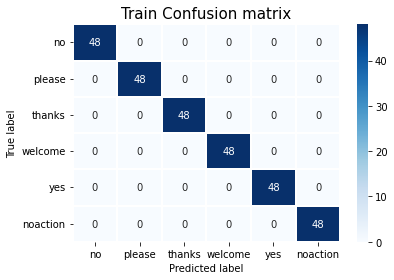

In [25]:
generate_confusion_matrix_accuracy(X_train,y_train,'Train')

3/3 [==============================] - 0s 13ms/step
Test Overall Multiclassification Accuracy Score across all classes: 0.97


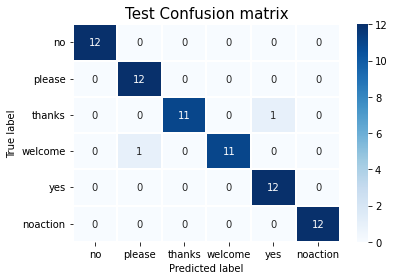

In [26]:
generate_confusion_matrix_accuracy(X_test,y_test,'Test')

In [27]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# predict on test data
y_pred = modelGRU.predict(X_test)

# convert predictions to binary labels
y_pred = (y_pred > 0.5)

# calculate precision, recall, f1-score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1_score)
print("Accuracy: ", accuracy)

3/3 [==============================] - 0s 15ms/step
Precision:  [1.         0.92307692 1.         1.         0.92307692 1.        ]
Recall:  [1.         1.         0.91666667 0.91666667 1.         1.        ]
F1-Score:  [1.         0.96       0.95652174 0.95652174 0.96       1.        ]
Accuracy:  0.9722222222222222
